In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
import numpy as np
import pandas as pd
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# Now you can import from src
from src.data_utils import load_and_process_taxi_data
rides = load_and_process_taxi_data(year=2023)

File already exists for 2023-01.
Loading data for 2023-01...
Total records: 3,066,766
Valid records: 2,993,140
Records dropped: 73,626 (2.40%)
Successfully processed data for 2023-01.
File already exists for 2023-02.
Loading data for 2023-02...
Total records: 2,913,955
Valid records: 2,845,058
Records dropped: 68,897 (2.36%)
Successfully processed data for 2023-02.
File already exists for 2023-03.
Loading data for 2023-03...
Total records: 3,403,766
Valid records: 3,331,705
Records dropped: 72,061 (2.12%)
Successfully processed data for 2023-03.
File already exists for 2023-04.
Loading data for 2023-04...
Total records: 3,288,250
Valid records: 3,214,922
Records dropped: 73,328 (2.23%)
Successfully processed data for 2023-04.
File already exists for 2023-05.
Loading data for 2023-05...
Total records: 3,513,649
Valid records: 3,435,875
Records dropped: 77,774 (2.21%)
Successfully processed data for 2023-05.
File already exists for 2023-06.
Loading data for 2023-06...
Total records: 3,30

In [4]:
from src.data_utils import transform_raw_data_into_ts_data

ts_data = transform_raw_data_into_ts_data(rides)
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2023-01-01 00:00:00,2,0
1,2023-01-01 01:00:00,2,0
2,2023-01-01 02:00:00,2,0
3,2023-01-01 03:00:00,2,0
4,2023-01-01 04:00:00,2,0


In [5]:
print(ts_data.shape)

(2277600, 3)


In [6]:
from src.config import TRANSFORMED_DATA_DIR
df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")
df.shape

(87620, 675)

In [7]:
from datetime import datetime

from src.data_utils import split_time_series_data

X_train, y_train, X_test, y_test = split_time_series_data(
    df,
    cutoff_date=datetime(2023, 9, 1, 0, 0, 0),
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(55900, 674)
(55900,)
(31720, 674)
(31720,)


In [8]:
def extract_fft_features_with_metadata(df, feature_col="rides", n_fft_features=10):
    """
    Extracts FFT-based features from time series data for each location ID.
    Returns a DataFrame with columns in the order: [FFT features, pickup_hour, pickup_location_id, target]

    Parameters:
        df (pd.DataFrame): Input DataFrame with 'pickup_hour', 'pickup_location_id', and feature column.
        feature_col (str): Column name containing the time series values (default is "rides").
        n_fft_features (int): Number of FFT features to extract (default is 10).

    Returns:
        pd.DataFrame: DataFrame with FFT features, pickup_hour, pickup_location_id, and target rides.
    """
    # List to store transformed data for each location
    transformed_data = []

    # Loop through each unique location ID
    for location_id in df["pickup_location_id"].unique():
        # Filter data for the current location ID
        location_data = df[df["pickup_location_id"] == location_id].sort_values("pickup_hour").reset_index(drop=True)
        
        # Extract numerical values from the feature column
        values = location_data[feature_col].values
        
        # Ensure there are enough rows for FFT
        if len(values) < 2:
            print(f"Skipping location_id {location_id}: Not enough data for FFT.")
            continue
        
        # Compute FFT and take only the first `n_fft_features` components
        fft_result = fft(values)
        fft_magnitude = np.abs(fft_result)[:n_fft_features]
        
        # Prepare rows with FFT features and metadata
        for i in range(len(location_data)):
            row = [*fft_magnitude,  # Unpack FFT features
                   location_data.loc[i, "pickup_hour"],
                   location_id,
                   location_data.loc[i, feature_col]]
            transformed_data.append(row)
    
    # Create column names
    fft_feature_cols = [f"fft_feature_{i+1}" for i in range(n_fft_features)]
    column_names = fft_feature_cols + ["pickup_hour", "pickup_location_id", "target"]
    
    # Convert the list of rows into a DataFrame
    transformed_df = pd.DataFrame(transformed_data, columns=column_names)
    
    return transformed_df

In [9]:
fft_features = extract_fft_features_with_metadata(ts_data)

In [10]:
fft_features.head()

,fft_feature_1,fft_feature_2,fft_feature_3,fft_feature_4,fft_feature_5,fft_feature_6,fft_feature_7,fft_feature_8,fft_feature_9,fft_feature_10,pickup_hour,pickup_location_id,target
0,33.0,5.394222,3.503057,4.963821,4.775043,4.32156,8.498243,5.760942,5.414939,2.261714,2023-01-01 00:00:00,2,0
1,33.0,5.394222,3.503057,4.963821,4.775043,4.32156,8.498243,5.760942,5.414939,2.261714,2023-01-01 01:00:00,2,0
2,33.0,5.394222,3.503057,4.963821,4.775043,4.32156,8.498243,5.760942,5.414939,2.261714,2023-01-01 02:00:00,2,0
3,33.0,5.394222,3.503057,4.963821,4.775043,4.32156,8.498243,5.760942,5.414939,2.261714,2023-01-01 03:00:00,2,0
4,33.0,5.394222,3.503057,4.963821,4.775043,4.32156,8.498243,5.760942,5.414939,2.261714,2023-01-01 04:00:00,2,0


In [11]:
from datetime import datetime

from src.data_utils import split_time_series_data

X_train_fft, y_train_fft, X_test_fft, y_test_fft = split_time_series_data(
    fft_features,
    cutoff_date=datetime(2023, 9, 1, 0, 0, 0),
    target_column="target"
)

print(X_train_fft.shape)
print(y_train_fft.shape)
print(X_test_fft.shape)
print(y_test_fft.shape)

(1516320, 12)
(1516320,)
(761280, 12)
(761280,)


In [12]:
X_train_fft.head()

,fft_feature_1,fft_feature_2,fft_feature_3,fft_feature_4,fft_feature_5,fft_feature_6,fft_feature_7,fft_feature_8,fft_feature_9,fft_feature_10,pickup_hour,pickup_location_id
0,33.0,5.394222,3.503057,4.963821,4.775043,4.32156,8.498243,5.760942,5.414939,2.261714,2023-01-01 00:00:00,2
1,33.0,5.394222,3.503057,4.963821,4.775043,4.32156,8.498243,5.760942,5.414939,2.261714,2023-01-01 01:00:00,2
2,33.0,5.394222,3.503057,4.963821,4.775043,4.32156,8.498243,5.760942,5.414939,2.261714,2023-01-01 02:00:00,2
3,33.0,5.394222,3.503057,4.963821,4.775043,4.32156,8.498243,5.760942,5.414939,2.261714,2023-01-01 03:00:00,2
4,33.0,5.394222,3.503057,4.963821,4.775043,4.32156,8.498243,5.760942,5.414939,2.261714,2023-01-01 04:00:00,2


In [13]:
past_ride_columns = [c for c in X_train_fft.columns if c.startswith("fft_")]
X_train_only_numeric = X_train_fft[past_ride_columns]
X_test_only_numeric = X_test_fft[past_ride_columns]

In [14]:
def fit_arma(data, order):
    model = ARIMA(data, order=(order[0], 0, order[1]))
    results = model.fit()
    return model, results

In [15]:
arma_model, arma_result = fit_arma(y_train, order=(2, 1))
arma_predictions = arma_result.forecast(steps=len(y_test))
arma_mae = mean_absolute_error(y_test, arma_predictions)
arma_mae

/opt/miniconda3/envs/taxi_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/taxi_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


18.11691184582702

In [16]:
arma_model, arma_result = fit_arma(y_train_fft, order=(2, 1))
arma_predictions = arma_result.forecast(steps=len(y_test_fft))
arma_mae = mean_absolute_error(y_test_fft, arma_predictions)
arma_mae

26.77860538182816

In [17]:
def fit_arima(data, order):
    model = ARIMA(data, order=order)
    results = model.fit()
    return model, results

In [18]:
arima_model, arima_result = fit_arima(y_train, order=(2, 0, 2))
arima_predictions = arima_result.forecast(steps=len(y_test))
arima_mae = mean_absolute_error(y_test, arima_predictions)
arima_mae

/opt/miniconda3/envs/taxi_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/taxi_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


18.343677692000963

In [19]:
arima_model, arima_result = fit_arima(y_train_fft, order=(2, 0, 1))
arima_predictions = arima_result.forecast(steps=len(y_test_fft))
arima_mae = mean_absolute_error(y_test_fft, arima_predictions)
arima_mae

26.77860538182816

15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:31 - cmdstanpy - INFO - Chain [1] done processing


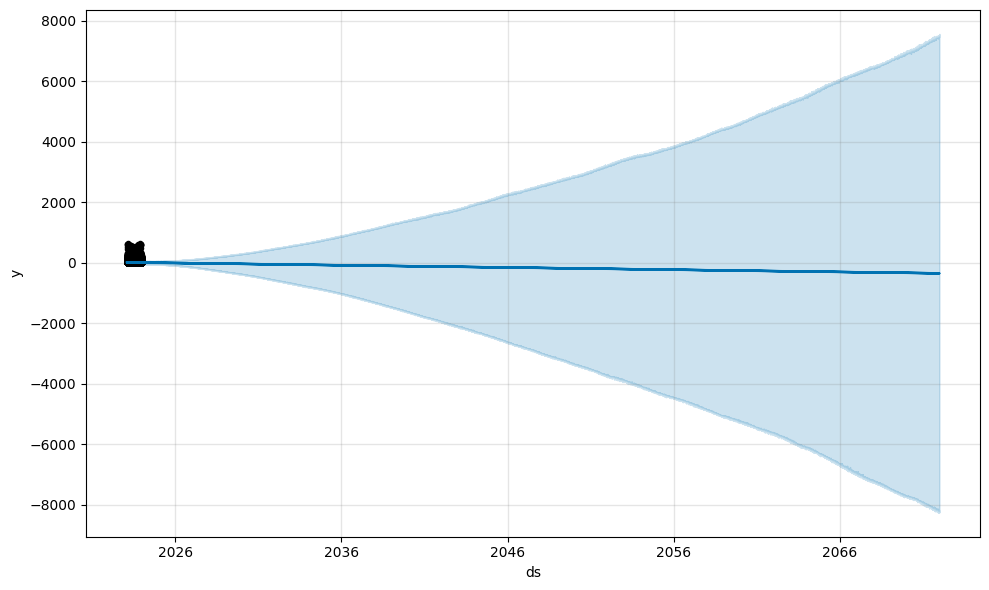

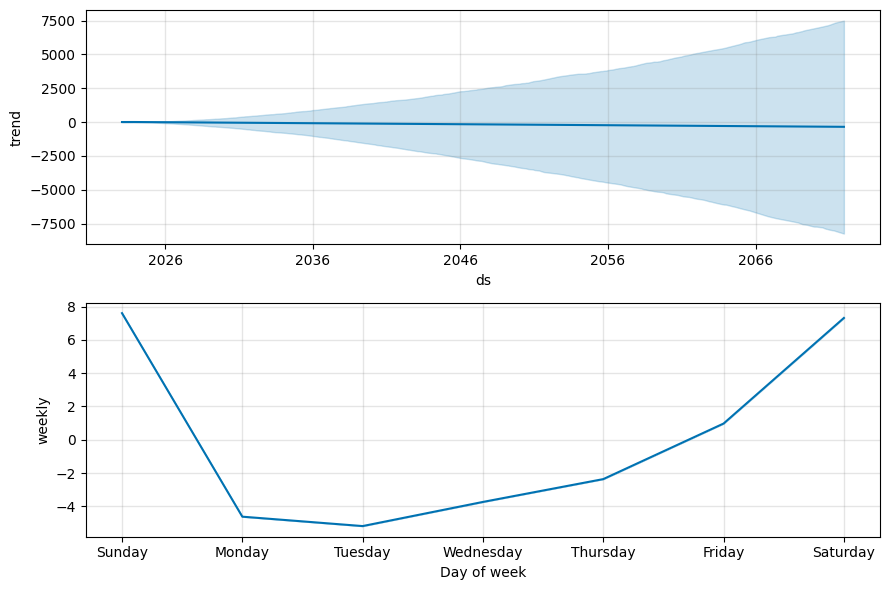

Mean Squared Error: 1634.1123712038711
Root Mean Squared Error: 40.4241557883881
Mean Absolute Error: 18.213925988865487
              ds        yhat   yhat_lower   yhat_upper
17856 2071-12-19 -337.238642 -8173.593922  7525.753408
17857 2071-12-20 -336.970218 -8238.664636  7528.539633
17858 2071-12-21 -349.215462 -8221.253644  7471.132901
17859 2071-12-22 -349.800525 -8240.853087  7531.542419
17860 2071-12-23 -348.370510 -8208.153944  7565.541835


In [22]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

def prepare_data_for_prophet(df):
    df_prophet = pd.DataFrame()
    df_prophet['ds'] = df['pickup_hour']
    df_prophet['y'] = df['target']  # Using the most recent ride data as the target
    #df_prophet['pickup_location_id'] = df['pickup_location_id']
    return df_prophet

# Step 2: Create and fit Prophet model
def fit_prophet_model(df_prophet):
    model = Prophet()
    #model.add_regressor('pickup_location_id')
    model.fit(df_prophet)
    return model

# Step 3: Make predictions
def make_predictions(model, periods=30):
    future_dates = model.make_future_dataframe(periods=periods)
    #future_dates['pickup_location_id'] = df_prophet['pickup_location_id'].iloc[-1]  # Assume last known location for future predictions
    forecast = model.predict(future_dates)
    return forecast

# Step 4: Visualize results
def visualize_results(model, forecast):
    fig1 = model.plot(forecast)
    fig2 = model.plot_components(forecast)
    plt.show()

# Step 5: Evaluate model performance
def evaluate_model(df_prophet, forecast):
    # Merge actual and predicted values
    evaluation_df = pd.merge(df_prophet, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
    
    # Calculate metrics
    mse = np.mean((evaluation_df['y'] - evaluation_df['yhat'])**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(evaluation_df['y'] - evaluation_df['yhat']))
    
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")

# Prepare data for Prophet
df_prophet = prepare_data_for_prophet(df)

# Split data into train and test sets
train_size = int(len(df_prophet) * 0.8)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]

# Fit model on training data
model = fit_prophet_model(df_train)

# Make predictions
forecast = make_predictions(model, periods=len(df_test))

# Visualize results
visualize_results(model, forecast)

# Evaluate model performance
evaluate_model(df_test, forecast)

# Print the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())